In [1]:
import os
import pickle
import datetime
from tqdm import tqdm
from typing import Any, Callable
import optax
import jax
import jax.random as jr
import jax.numpy as np
import numpy 
from jax.flatten_util import ravel_pytree
from jax import Array, vmap
import matplotlib.pyplot as plt
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from svae_control.config import Config
from pathlib import Path


from dataclasses import asdict
from pathlib import Path

import jax
from jax import random as jr
from matplotlib import pyplot as plt

import wandb
from svae_control import network
from svae_control.config import Config
from svae_control.svae import SVAE
from svae_control.train import Trainer
from svae_control.utils.dataclass_utils import LDSParams
from svae_control.utils.setup_utils import get_args, get_beta_schedule, load_dataset
from svae_control.utils.dataclass_utils import InputData
from svae_control.utils.kernel_ridge import GPUKernelRidge, sweep_krr, standardize

CACHE_DIR = 'tests/results'
SEED = 50
TOLERANCE = 1e-1

YAML_PREFIX = f"{os.getcwd()}"
PARAM_PREFIX = f"{os.getcwd()}/params/svae"
YAML_PREFIX, PARAM_PREFIX

('/home/james/projects/master_project/svae-control/src/svae_control/notebooks/corrupted_image_observations',
 '/home/james/projects/master_project/svae-control/src/svae_control/notebooks/corrupted_image_observations/params/svae')

# Load Data

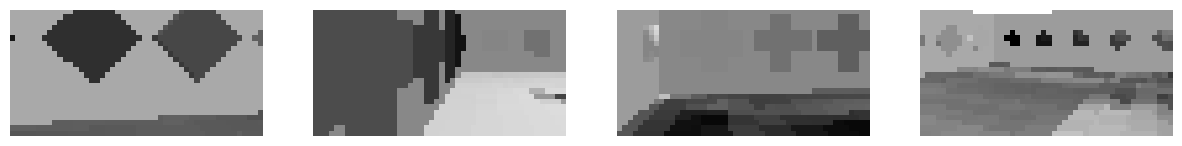

((200, 100, 24, 48), (200, 100, 3), (50, 100, 24, 48), (50, 100, 3))

In [7]:
data_dir = "/home/james/projects/master_project/svae-control/src/svae_control/data/"
latents = np.load(os.path.join(data_dir, "cifar_latents.npy"))
observations = np.load(os.path.join(data_dir, "cifar_greyscale_images.npy")) / 255
controls = np.load(os.path.join(data_dir, "cifar_controls.npy"))

observations = observations[:, :, 18:42, :]

# plot images before flattening 
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].imshow(observations[0, i * 30], cmap="grey", vmin=0, vmax=1)
    ax[i].axis("off")
plt.show()

# standardise
N = 200
train_X, val_X = observations[:N], observations[N:]
train_Y, val_Y = latents[:N], latents[N:]

train_X, val_X = standardize(train_X, val_X)
train_Y, val_Y = standardize(train_Y, val_Y)

train_X.shape, train_Y.shape, val_X.shape, val_Y.shape

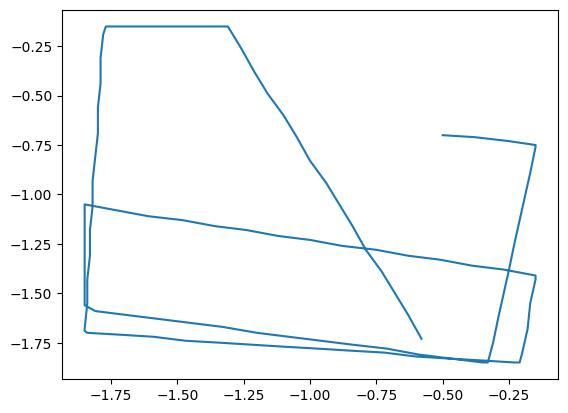

In [5]:
plt.figure()
plt.plot(latents[0, :, 0], latents[0, :, 1])
plt.show()

# Config

In [8]:
config_dir = f"{YAML_PREFIX}/corrupted_image_observations_config.yaml"
yaml_config = Path(config_dir)
config = Config.from_yaml(yaml_config)

key = jr.PRNGKey(config.training.seed)
data_key, model_key, trainer_key = jr.split(key, 3)

train_data = InputData(obs=train_X[..., None], targets=train_Y)
val_data = InputData(obs=val_X[..., None], targets=val_Y) 

train_data.obs.shape, val_data.obs.shape

((200, 100, 24, 48, 1), (50, 100, 24, 48, 1))

In [9]:
config

Config(data=DataConfig(dataset='GPS', obs_shape=[24, 48, 1], T=100, normalise_obs=True, normalise_pixels=True, train_frac=0.8), model=ModelConfig(latent_dim=32, encoder=NNDistConfig(dist_type='GaussianNN', backbone=NNConfig(nn_type='CNN', hidden_dims=[62, 128], nn_args={}), head=NNConfig(nn_type='CNN', hidden_dims=[256], nn_args={}), optim=OptimiserConfig(lr=0.0005, optim_type='adam', lr_schedule='constant', weight_decay=0.0), kwargs={}), decoder=NNDistConfig(dist_type='DiagGaussianFixedVarNN', backbone=NNConfig(nn_type='MLP', hidden_dims=[256, 256], nn_args={}), head=NNConfig(nn_type='MLP', hidden_dims=[256], nn_args={}), optim=OptimiserConfig(lr=0.001, optim_type='adam', lr_schedule='constant', weight_decay=0.0), kwargs={'var_scale': 1.0}), prior=LDSPriorConfig(optim=OptimiserConfig(lr=0.001, optim_type='adam', lr_schedule='constant', weight_decay=0.0), init_dynamics_noise_scale=0.1)), training=TrainingConfig(num_samples=1, batch_size=4, seed=0, mask_size=30, num_masks=0, uninformati

In [10]:
prior = LDSParams.init(config.model.latent_dim)
enc = getattr(network, config.model.encoder.dist_type)(
    config.model.encoder, config.model.latent_dim
)
dec = getattr(network, config.model.decoder.dist_type)(
    config.model.decoder, config.data.obs_dim_flat
)

model = SVAE(
    generation_network=dec, recognition_network=enc, config=config, key=model_key
)
trainer = Trainer(
    model=model,
    config=config,
    prior_params=prior,
    beta_schedule=get_beta_schedule(config.training.beta),
    key=trainer_key,
    logger=None,
)
loss, r2, trained_params = trainer.train(train_data, val_data)

2025-08-25 11:43:52.147347: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.

00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [1:48:02<00:00,  3.86it/s, kl=0.028, loss=1.047, obs_ll=-1.019, r2_post=0.891]

In [11]:
# save params
filename = f"{PARAM_PREFIX}_params.pkl"
with open(filename, 'wb') as f:
    pickle.dump(trainer.params, f)

# save loss tot
loss = np.array(loss)
filename = f"{PARAM_PREFIX}_training_loss.pkl"
np.save(filename, loss)

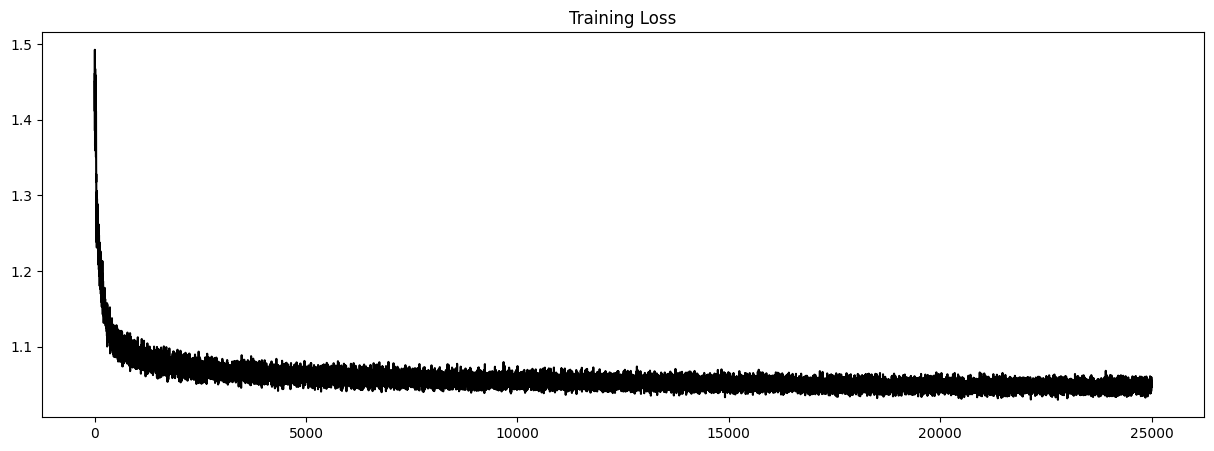

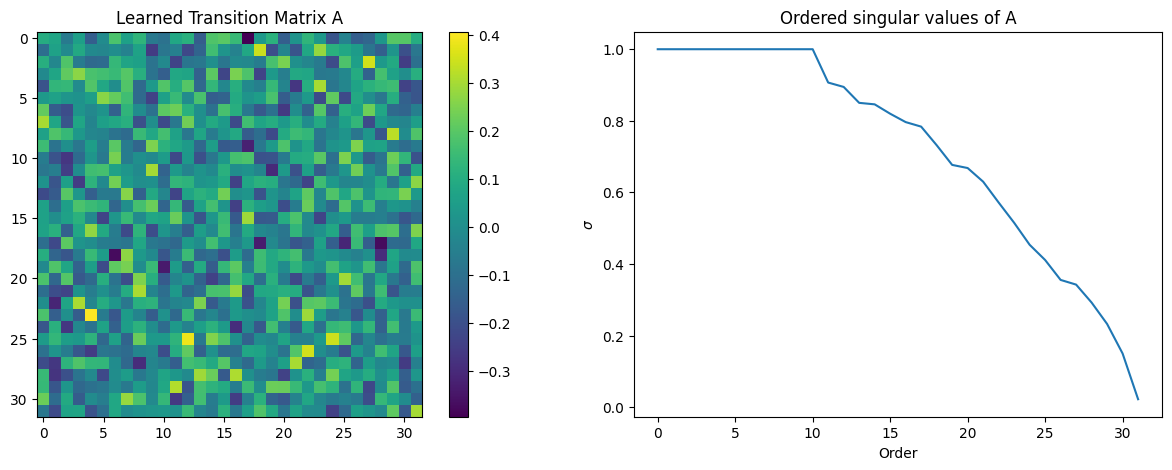

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(loss, color="black")
plt.title("Training Loss")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
A = numpy.array(trainer.params[0].A)
im = ax[0].imshow(A)
ax[0].set_title("Learned Transition Matrix A")
fig.colorbar(im, ax=ax[0])

U, S, VT = numpy.linalg.svd(A)
rank = numpy.linalg.matrix_rank(A)
ax[1].plot(numpy.arange(S.shape[0]), S)
ax[1].set_title("Ordered singular values of A")
ax[1].set_ylabel(r"$\sigma\ $")
ax[1].set_xlabel("Order")

plt.show()

# Check Latent State Quality with Kernel Ridge

In [13]:
apply = vmap(model.apply, (None, 0))

train_ts_means = []
val_ts_means = []
for i in tqdm(range(train_X.shape[0]), desc="Getting Posterior Means"):
    train_ts_means.append(apply(trained_params, train_X[None, i, ..., None]).smoothed_means)
    val_ts_means.append(apply(trained_params, val_X[None, i, ..., None]).smoothed_means)

train_ts_means = np.concat(train_ts_means)
val_ts_means = np.concat(val_ts_means)

# standardize the posterior means output
train_ts_means, val_ts_means = standardize(train_ts_means, val_ts_means)



etting Posterior Means: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:43<00:00,  1.22it/s]

In [14]:
train_ts_means.shape, val_ts_means.shape

((200, 100, 32), (200, 100, 32))

In [15]:
sigma_range = np.arange(0.01, 4, 0.1)
lambda_range = np.arange(0.001, 0.2, 0.02)
krr, aux = sweep_krr(train_ts_means, train_Y, val_ts_means, val_Y, sigma_range, lambda_range, batch_frac=0.5)
aux


itting KRR: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.99s/it]

{'sigma': Array(2.81, dtype=float32),
 'lambda': Array(0.061, dtype=float32),
 'r2': Array(0.8486866, dtype=float32)}

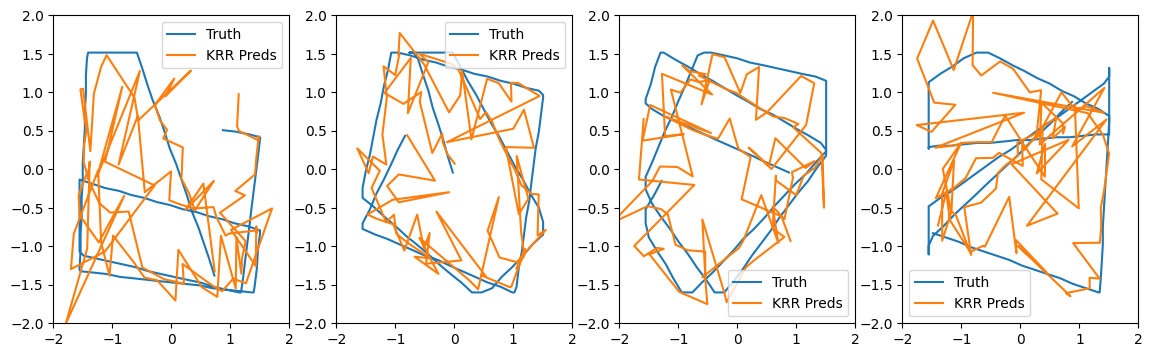

In [16]:
krr_preds = krr.predict(train_ts_means)
# val_krr_preds = krr.predict(val_X)

fig, ax = plt.subplots(1, 4, figsize=(14, 4))
counter = 0
for i in range(4):
    ax[i].plot(train_Y[counter, :, 0], train_Y[counter, :, 1], label="Truth")
    ax[i].plot(krr_preds[counter, :, 0], krr_preds[counter, :, 1], label="KRR Preds")
    ax[i].set_xlim(-2, 2)
    ax[i].set_ylim(-2, 2)
    ax[i].legend()
    counter += 1
plt.show()